## Importing libs

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
sns.set() # apply the seaborn defaults to plotted figures (e.g. theme, scaling, color palette), instead of matplotlib's

In [3]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.0.0


In [4]:
import warnings
from time import time, strftime

In [ ]:
strftime('%X')

## Preparing the Fashion-MNIST dataset
[Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset of Zalando’s article images, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28×28 grayscale image, associated with a label from 10 classes.

**NOTE:** you should have the .csv files in the directory listed below

In [5]:
# confirm that you have fashion-mnist_train.csv and fashion-mnist_test.csv (unzipped)
!ls ../fashion-mnist-dataset/

fashion-mnist_test.csv
fashion-mnist_train.csv
README.txt


In [6]:
PATH_TO_DATA = os.path.join("..", "fashion-mnist-dataset")

# the datasets have the label on the first column and the image pixels on the following 784
train_dataset_csv = pd.read_csv(os.path.join(PATH_TO_DATA, "fashion-mnist_train.csv"), delimiter=',')
test_dataset_csv = pd.read_csv(os.path.join(PATH_TO_DATA, "fashion-mnist_test.csv"), delimiter=',')

In [7]:
IMG_WIDTH = IMG_HEIGHT = 28
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH) # grayscale images
IMG_FLAT_SHAPE = (IMG_HEIGHT*IMG_WIDTH, )

CLASS_NAME = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
CLASS_COUNT = len(CLASS_NAME)

## Split train into train + validation

In [8]:
# random seed for splitting the data deterministically
RANDOM_SEED = 886
np.random.seed(RANDOM_SEED)

In [9]:
from sklearn.model_selection import train_test_split

train_dataset, validation_dataset = train_test_split(train_dataset_csv, train_size=0.8, shuffle=True, random_state=RANDOM_SEED)
print(f"train:      {train_dataset.shape}") # 80%
print(f"validation: {validation_dataset.shape}") # 20%

test_dataset = test_dataset_csv
print(f"test:       {test_dataset.shape}")

train:      (48000, 785)
validation: (12000, 785)
test:       (10000, 785)


## Separate labels and images

In [10]:
ys_train = train_dataset["label"].values
ys_val   = validation_dataset["label"].values
ys_test  = test_dataset["label"].values

print(ys_train.shape, "min:", ys_train.min(), "max:", ys_train.max())
print(ys_val.shape,   "min:", ys_val.min(),   "max:", ys_val.max())
print(ys_test.shape,  "min:", ys_test.min(),  "max:", ys_test.max())

(48000,) min: 0 max: 9
(12000,) min: 0 max: 9
(10000,) min: 0 max: 9


In [11]:
xs_train = train_dataset.loc[:, train_dataset.columns != "label"].values
xs_val   = validation_dataset.loc[:, validation_dataset.columns != "label"].values
xs_test  = test_dataset.loc[:, test_dataset.columns != "label"].values

print(xs_train.shape, "min:", xs_train.min(), "max:", xs_train.max())
print(xs_val.shape,   "min:", xs_val.min(),   "max:", xs_val.max())
print(xs_test.shape,  "min:", xs_test.min(),  "max:", xs_test.max())

(48000, 784) min: 0 max: 255
(12000, 784) min: 0 max: 255
(10000, 784) min: 0 max: 255


In [12]:
def each_count(array):
    count = np.bincount(array)
    nonzero_count = np.nonzero(count)[0]
    return zip(nonzero_count, count[nonzero_count])

In [13]:
class_count_train = list(each_count(ys_train))
class_count_val   = list(each_count(ys_val))
class_count_test  = list(each_count(ys_test))
print("              Train         Validation    Test")
for label in range(CLASS_COUNT):
    print(f"{(CLASS_NAME[label] + ':'):<12}  "
          f"{class_count_train[label][1]} ({class_count_train[label][1] / ys_train.shape[0]:.2f}%)  "
          f"{class_count_val[label][1]} ({class_count_val[label][1] / ys_val.shape[0]:.2f}%)  "
          f"{class_count_test[label][1]} ({class_count_test[label][1] / ys_test.shape[0]:.2f}%)")

              Train         Validation    Test
T-shirt/top:  4863 (0.10%)  1137 (0.09%)  1000 (0.10%)
Trouser:      4795 (0.10%)  1205 (0.10%)  1000 (0.10%)
Pullover:     4817 (0.10%)  1183 (0.10%)  1000 (0.10%)
Dress:        4770 (0.10%)  1230 (0.10%)  1000 (0.10%)
Coat:         4820 (0.10%)  1180 (0.10%)  1000 (0.10%)
Sandal:       4769 (0.10%)  1231 (0.10%)  1000 (0.10%)
Shirt:        4771 (0.10%)  1229 (0.10%)  1000 (0.10%)
Sneaker:      4764 (0.10%)  1236 (0.10%)  1000 (0.10%)
Bag:          4778 (0.10%)  1222 (0.10%)  1000 (0.10%)
Ankle boot:   4853 (0.10%)  1147 (0.10%)  1000 (0.10%)


## Normalize images and one-hot encode labels

In [14]:
xs_train = xs_train.astype('float32') / 255.0
xs_val = xs_val.astype('float32') / 255.0
xs_test = xs_test.astype('float32') / 255.0

**Let's forget about the test set for now..** just assume it doesn't exist (but don't worry, we'll come back to it at the end).

In [15]:
print(f"xs_train: mean={xs_train.mean():>8.4f}, stddev={xs_train.std():>7.4f}")

# NOTE that we must use stats from train data to normalize the val and test sets aswell
mean, std = xs_train.mean(), xs_train.std()
X_train = (xs_train - mean) / std

print(f"X_train:  mean={X_train.mean():>8.4f}, stddev={X_train.std():>7.4f}")

xs_train: mean=  0.2862, stddev= 0.3529
X_train:  mean=  0.0000, stddev= 1.0000


In [16]:
X_val = (xs_val - mean) / std
print(f"xs_val: mean={xs_val.mean():>8.4f}, stddev={xs_val.std():>7.4f}")
print(f"X_val:  mean={X_val.mean():>8.4f}, stddev={X_val.std():>7.4f}") # mean should be close to 0 and stddev close to 1

xs_val: mean=  0.2858, stddev= 0.3526
X_val:  mean= -0.0011, stddev= 0.9992


In [17]:
def onehot_encode(ys):
    n_examples, *_ = ys.shape
    onehot = np.zeros(shape=(n_examples, CLASS_COUNT))
    onehot[np.arange(n_examples), ys] = 1
    return onehot

In [18]:
Y_train = onehot_encode(ys_train)
print(ys_train.shape, Y_train.shape)

(48000,) (48000, 10)


In [19]:
Y_val = onehot_encode(ys_val)
print(ys_val.shape, Y_val.shape)

(12000,) (12000, 10)


## Add helper functions

In [20]:
def plot_history(history, model=None, n_epochs=None, batch_size=None, title_prefix=None):
    plot_title = ("" if title_prefix is None else (title_prefix + "\n")) + "Train history"
    info = []
    if n_epochs is not None:
        info.append(f"{n_epochs} epochs")
    if batch_size is not None:
        info.append(f"{batch_size} batch size")
    if model is not None:
        info.append(f"{model.optimizer.get_config()['name']} optimizer")
    if len(info) > 0:
        plot_title += f" ({', '.join(info)})"
    
    # leave only "loss" and "val_loss" for plotting
    loss_data = pd.DataFrame({k: v for k, v in history.items() if (k == "loss" or k == "val_loss")})
    loss_data.index += 1 # start counting the epochs at 1, not 0
    lineplot = sns.lineplot(data=loss_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Loss" + f" ({model.loss})" if model is not None else "")
    plt.show()

    # leave only "accuracy" and "val_accuracy" for plotting
    acc_data = pd.DataFrame({k: v for k, v in history.items() if (k == "accuracy" or k == "val_accuracy")})
    acc_data.index += 1 # start counting the epochs at 1, not 0
    lineplot = sns.lineplot(data=acc_data)
    lineplot.set_title(plot_title)
    lineplot.set_xlabel("epoch")
    lineplot.set_ylabel("Accuracy")
    plt.show()

In [21]:
def train(model, X_train, Y_train, X_val, Y_val, n_epochs=64, batch_size=1024, 
          min_delta=0.003, patience=3, early_stopping=True, plot_title=None, plot=True):
    best_model_path = os.path.join("models", f"best_model{model.name}.h5")
    if not os.path.exists(os.path.dirname(best_model_path)):
        os.makedirs(os.path.dirname(best_model_path))
    
    callbacks = [keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath=best_model_path, save_best_only=True)]
    if early_stopping:
        callbacks.append(keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=patience))
    
    print("Starting to train...")
    start = time()
    hist = model.fit(
        x=X_train, y=Y_train,
        validation_data=(X_val, Y_val),
        epochs=n_epochs,
        batch_size=batch_size,
        callbacks=callbacks
    ).history
    end = time()
    print(f"\nDone.\nTraining took {(end - start):.2f}s")
    
    if os.path.exists(best_model_path):
        model = keras.models.load_model(best_model_path)
    
    if plot:
        plot_history(hist, model, n_epochs, batch_size, plot_title)
    
    return hist, model

In [22]:
# ref.: https://www.tensorflow.org/tutorials/keras/classification

def plot_image_with_prediction(xs, ys, ys_pred, num_rows=5, num_cols=3):
    def plot_image(i, predictions_array, true_label, img):
        true_label, img = true_label[i], img[i]
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img.reshape(IMG_SHAPE), cmap=plt.cm.binary)
        predicted_label = np.argmax(predictions_array)
        color = 'blue' if predicted_label == true_label else 'red'
        plt.xlabel("{} {:2.0f}% ({})".format(CLASS_NAME[predicted_label],
                                             100*np.max(predictions_array),
                                             CLASS_NAME[true_label]),
                                             color=color)

    def plot_value_array(i, predictions_array, true_label):
        true_label = true_label[i]
        plt.grid(False)
        plt.xticks(range(10))
        plt.yticks([])
        thisplot = plt.bar(range(10), predictions_array, color="#777777")
        plt.ylim([0, 1])
        predicted_label = np.argmax(predictions_array)
        thisplot[predicted_label].set_color('red')
        thisplot[true_label].set_color('blue')
    
    # plot the first few test images, their predicted labels, and the true labels
    # color correct predictions in blue and incorrect predictions in red    
    num_images = num_rows * num_cols
    plt.figure(figsize=(4 * num_cols, 2 * num_rows))
    for i in range(num_images):
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
        plot_image(i, ys_pred[i], ys, xs)
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
        plot_value_array(i, ys_pred[i], ys)
    plt.tight_layout()
    plt.show()

In [23]:
from sklearn.metrics import confusion_matrix, f1_score

In [24]:
def print_cm(ys, ys_pred, class_names, figsize=(10, 9), fontsize=12):
    #cm = confusion_matrix(ys, ys_pred)
    #df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    cm = np.flip(confusion_matrix(ys, ys_pred), axis=0)
    df_cm = pd.DataFrame(cm, index=class_names[::-1], columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    heatmap.set_ylim(*heatmap.get_xlim())
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## 1. Baseline
Explore Neural Networks with Fashion-MNIST. What is the accuracy? Describe your Neural Network architecture.

In [25]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Reshape
from tensorflow.keras.regularizers import l2

## 1.1. MLP

In [33]:
model = keras.Sequential([
    Input(IMG_FLAT_SHAPE), # 28 * 28 = 784 pixels
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "MLP_baseline")

In [34]:
# NOTE use 'categorical_crossentropy' since `labels` is a one-hot encoded vector
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "MLP_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 44s 926us/sample - loss: 0.5284 - accuracy: 0.8168 - val_loss: 0.4111 - val_accuracy: 0.8562
Epoch 2/64
48000/48000 [==============================] - 41s 850us/sample - loss: 0.3859 - accuracy: 0.8663 - val_loss: 0.4002 - val_accuracy: 0.8581
Epoch 3/64
48000/48000 [==============================] - 42s 880us/sample - loss: 0.3451 - accuracy: 0.8790 - val_loss: 0.3919 - val_accuracy: 0.8645
Epoch 4/64
48000/48000 [==============================] - 41s 863us/sample - loss: 0.3202 - accuracy: 0.8864 - val_loss: 0.3552 - val_accuracy: 0.8746
Epoch 5/64
48000/48000 [==============================] - 41s 856us/sample - loss: 0.2982 - accuracy: 0.8952 - val_loss: 0.3375 - val_accuracy: 0.8809
Epoch 6/64
48000/48000 [==============================] - 42s 872us/sample - loss: 0.2807 - accuracy: 0.8995 - val_loss: 0.3375 - val_accuracy: 0.8816
Epoch 7/64
48000/48000 

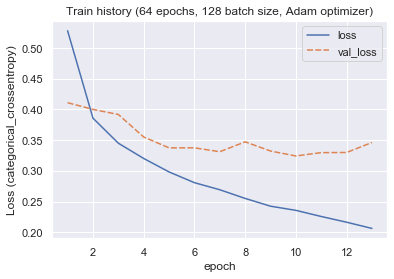

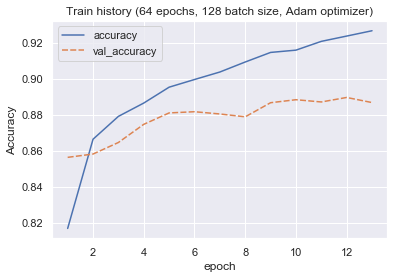

In [37]:
history, best_model = train(model, X_train, Y_train, X_val, Y_val, 
                            n_epochs=64, batch_size=128)

In [38]:
ys_val_pred = best_model.predict(xs_val)

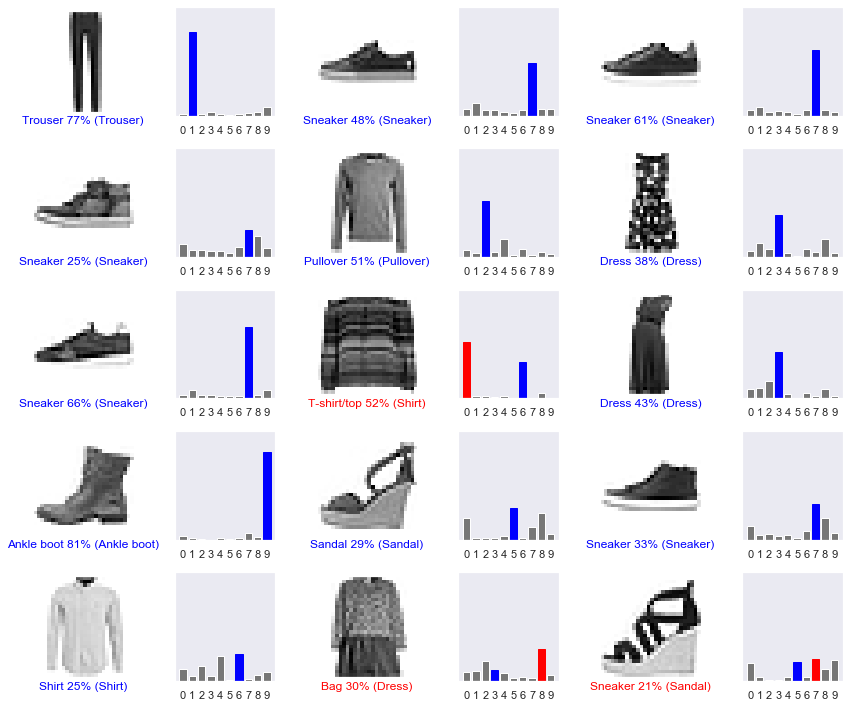

In [39]:
plot_image_with_prediction(xs_val, ys_val, ys_val_pred)

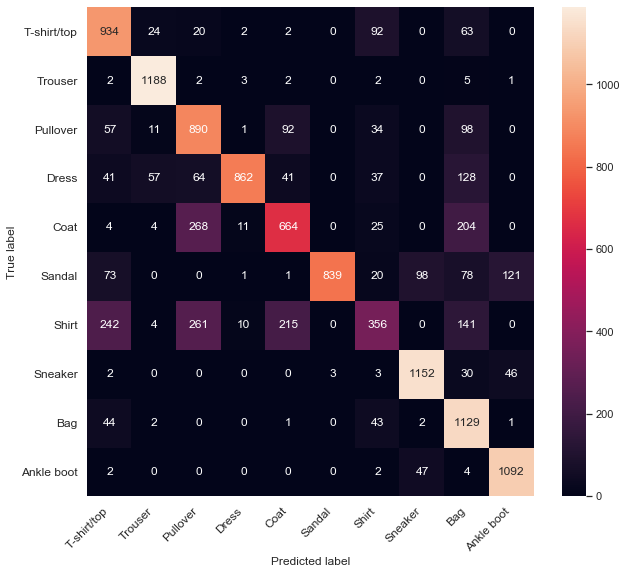

In [40]:
print_cm(ys_val, np.argmax(ys_val_pred, axis=1), CLASS_NAME)

## 1.2. CNN

In [26]:
# obs.: padding='valid' by default (i.e. no padding)
conv_model = keras.Sequential([
    Reshape((28, 28, 1), input_shape=(784,)),
    Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)), # 28x28 -> 14x14 feature map
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)), # 14x14 -> 7x7 feature map
    Flatten(), # 7*7*64 = 3136
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "CNN_baseline")

In [27]:
conv_model.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [28]:
conv_model.summary()

Model: "CNN_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 10)               

In [29]:
conv_model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 4s 90us/sample - loss: 0.5341 - accuracy: 0.8207 - val_loss: 0.3900 - val_accuracy: 0.8717
Epoch 2/64
48000/48000 [==============================] - 2s 50us/sample - loss: 0.3595 - accuracy: 0.8839 - val_loss: 0.3422 - val_accuracy: 0.8914
Epoch 3/64
48000/48000 [==============================] - 2s 50us/sample - loss: 0.3230 - accuracy: 0.8967 - val_loss: 0.3227 - val_accuracy: 0.8974
Epoch 4/64
48000/48000 [==============================] - 3s 54us/sample - loss: 0.3011 - accuracy: 0.9043 - val_loss: 0.3357 - val_accuracy: 0.8890
Epoch 5/64
48000/48000 [==============================] - 3s 59us/sample - loss: 0.2828 - accuracy: 0.9111 - val_loss: 0.3137 - val_accuracy: 0.8947
Epoch 6/64
48000/48000 [==============================] - 3s 57us/sample - loss: 0.2685 - accuracy: 0.9160 - val_loss: 0.2890 - val_accuracy: 0.9068
Epoch 7/64
48000/48000 [===========

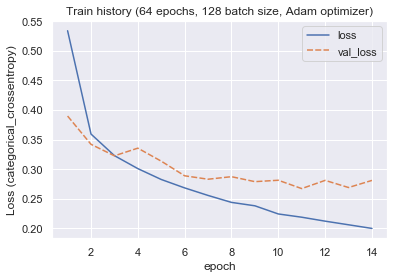

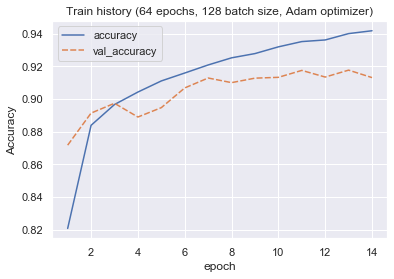

In [30]:
conv_history, best_conv_model = train(conv_model, X_train, Y_train, X_val, Y_val, 
                                      n_epochs=64, batch_size=128)

## 1.3. CNN with dropout and batch normalization

In [31]:
from tensorflow.keras.layers import Dropout, BatchNormalization, ReLU

In [32]:
# obs.: padding='valid' by default (i.e. no padding)
conv_v2_model = keras.Sequential([
    Reshape((28, 28, 1), input_shape=(784,)),
    Conv2D(32, (5, 5), padding='same', input_shape=(28, 28, 1)),
    BatchNormalization(),
    ReLU(),
    Dropout(0.4),
    MaxPooling2D((2, 2)), # 28x28 -> 14x14 feature map
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    ReLU(),
    Dropout(0.4),
    MaxPooling2D((2, 2)), # 14x14 -> 7x7 feature map
    Flatten(), # 7*7*64 = 3136
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))
], "CNN_v2_baseline")

In [33]:
conv_v2_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

In [34]:
conv_v2_model.summary()

Model: "CNN_v2_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
re_lu (ReLU)                 (None, 28, 28, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)    

In [35]:
conv_v2_model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

Starting to train...
Train on 48000 samples, validate on 12000 samples
Epoch 1/64
48000/48000 [==============================] - 5s 95us/sample - loss: 0.5837 - accuracy: 0.8087 - val_loss: 0.6514 - val_accuracy: 0.7992
Epoch 2/64
48000/48000 [==============================] - 4s 80us/sample - loss: 0.3998 - accuracy: 0.8652 - val_loss: 0.4961 - val_accuracy: 0.8614
Epoch 3/64
48000/48000 [==============================] - 4s 80us/sample - loss: 0.3604 - accuracy: 0.8803 - val_loss: 0.4743 - val_accuracy: 0.8503
Epoch 4/64
48000/48000 [==============================] - 4s 79us/sample - loss: 0.3413 - accuracy: 0.8858 - val_loss: 0.4610 - val_accuracy: 0.8684
Epoch 5/64
48000/48000 [==============================] - 4s 80us/sample - loss: 0.3182 - accuracy: 0.8942 - val_loss: 0.4330 - val_accuracy: 0.8700
Epoch 6/64
48000/48000 [==============================] - 4s 78us/sample - loss: 0.3105 - accuracy: 0.8978 - val_loss: 0.4551 - val_accuracy: 0.8606
Epoch 7/64
48000/48000 [===========

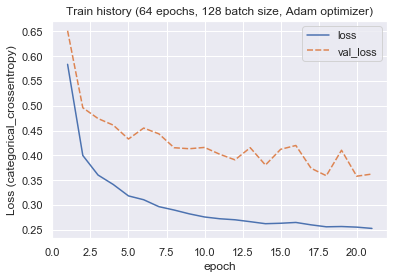

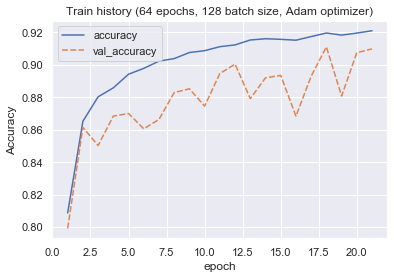

In [36]:
conv_v2_history, best_conv_v2_model = train(conv_v2_model, X_train, Y_train, X_val, Y_val, 
                                            n_epochs=64, batch_size=128)

## 2. Using PCA
Re-do the ﬁrst experiment considering the PCA dimensionality reduction. Consider three diﬀerent energies (variance) for reducing the image dimensionality. What are the conclusions when using PCA in this problem? Does the accuracy improve?

In [55]:
from sklearn.decomposition import PCA

## 2.1. 99% explained variance

## 2.2. 95% explained variance

## 2.3. 90% explained variance

## 2.4. First 3 principal components

In [56]:
pca_3pc = PCA(n_components=3)

In [100]:
def print_info(array, name):
    print(f"{name+':':<9} {array.dtype.name:<7} {str(array.shape):<12} "
          f"| min: {array.min():>5.2f} | max: {array.max():>5.2f} "
          f"| mean: {array.mean():>5.3f} | std: {array.std():>5.3f}")

In [101]:
print_info(X_train, "X_train")
print_info(xs_train, "xs_train")
print_info(Y_train, "Y_train")
print_info(ys_train, "ys_train")

X_train:  float32 (48000, 784) | min: -0.81 | max:  2.02 | mean: 0.000 | std: 1.000
xs_train: float32 (48000, 784) | min:  0.00 | max:  1.00 | mean: 0.286 | std: 0.353
Y_train:  float64 (48000, 10)  | min:  0.00 | max:  1.00 | mean: 0.100 | std: 0.300
ys_train: int64   (48000,)     | min:  0.00 | max:  9.00 | mean: 4.495 | std: 2.879


In [87]:
pca_3pc_result = pca_3pc.fit_transform(xs_train)

In [114]:
print(f"Explained variation per principal component:")
for i, (var, cumsum) in enumerate(zip(pca_3pc.explained_variance_ratio_, np.cumsum(pca_3pc.explained_variance_ratio_))):
    print(f"PC {i+1}: {var:.4f} (cumulative sum: {cumsum:.2f})")

Explained variation per principal component:
PC 1: 0.2896 (cumulative sum: 0.29)
PC 2: 0.1775 (cumulative sum: 0.47)
PC 3: 0.0606 (cumulative sum: 0.53)


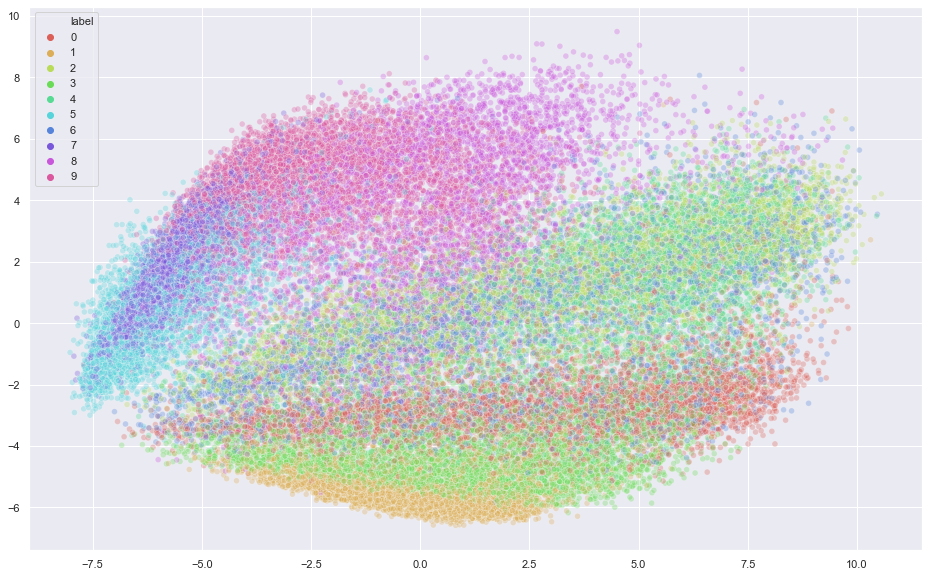

In [118]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=pca_3pc_result[..., 0], # PC 1
    y=pca_3pc_result[..., 1], # PC 2
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=train_dataset,
    legend="full",
    alpha=0.3
)

In [121]:
from mpl_toolkits.mplot3d import Axes3D

In [132]:
%matplotlib inline

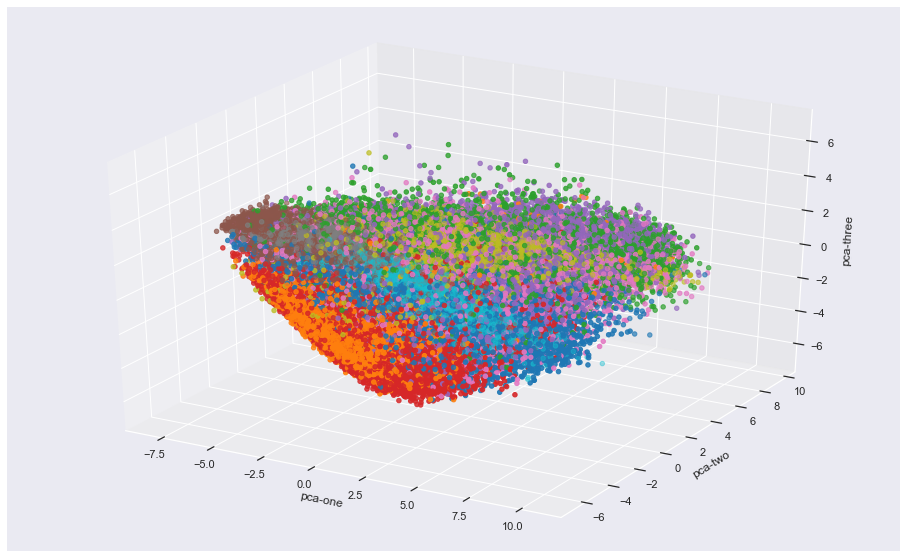

In [133]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=pca_3pc_result[..., 0], # PC 1
    ys=pca_3pc_result[..., 1], # PC 2
    zs=pca_3pc_result[..., 2], # PC 3
    c=ys_train, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## 3. Using Autoencoders
Re-do the ﬁrst experiment considering Autoencoders for reducing the image dimensionality. Consider two diﬀerent latent vector size for reducing the image dimensionality. What are the conclusions when using Autoencoders in this problem? Does accuracy improve?

Autoencoders are a branch of neural network which attempt to compress the information of the input variables into a reduced dimensional space and then recreate the input data set. Typically the autoencoder is trained over a number of iterations using gradient descent, minimizing the mean squared error. The key component is the “bottleneck” hidden layer. This is where the information from the input has been compressed. By extracting this layer from the model, each node can now be treated as a variable in the same way each chosen principal component is used as a variable in following models.


## 4. Using clustering techniques
Explore two clustering algorithms using the reduced features (PCA or Autoencoders). Do the clusters make sense? Check the validity/quality of your clusters.